In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import bisect
from scipy import spatial

import inv_cdfs as icdf
import agents_network as anet

We start by creating $n$ agents which are in $\mathbb{R}^p$. These agents are split in two groups, some of them are labelled $y=1$ and others $y=2$.

In [2]:
npeers, p = 4, 2 # number of agents, dimension
n1 = int(3*npeers/4)
n2 = npeers-n1
t, R = 2*np.pi*np.random.randn(n1,1), 3
r = R*(1.5 + .2*np.random.randn(n1,1)) # radius
X1 = np.hstack((np.cos(t)*r, np.sin(t)*r));
X = np.vstack((X1, np.random.randn(n2,2)))
y = np.vstack(( np.ones([n1,1]), 2*np.ones([n2,1]) ))

We plot the agents. Those in blue are labelled $y=1$ and in orange are labelled $y=2$.

(-3.5816398833398995,
 0.9574959437233828,
 -4.210658127821856,
 4.404646868830241)

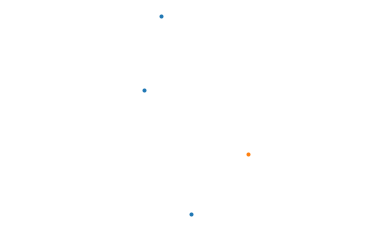

In [3]:
I = np.nonzero(y==1)[0]
J = np.nonzero(y==2)[0]
plt.plot(X[I,0], X[I,1], '.')
plt.plot(X[J,0], X[J,1], '.')
plt.axis('equal')
plt.axis('off')

The following function generate specific datas for each agent. Depending on their labelled and $\|x\|_2$, each agent received data from different distributions.

In [4]:
def create_data(x, y ,nsamples=1000):
    if y==1:
        data = np.random.poisson(np.linalg.norm(x), nsamples)
    elif y==2:
        data = ss.expon.rvs(np.linalg.norm(x), size=nsamples)
    else:
        print("choose y in {1,2}")
    return data

We define DATA to be list of data received by each agent. Then, we plot two examples :

In [5]:
nsamples = 4000 # number of data for each agent
DATA = [create_data(X[k], y[k], nsamples=nsamples) for k in range(npeers)]

i, j = np.random.choice(I), np.random.choice(J)
print('i=', i, 'et j=', j)
print('data for an element of I : ', DATA[i][:10])
print('data for an element of J : ', DATA[j][:10])

i= 0 et j= 3
data for an element of I :  [8 5 2 1 3 2 5 4 5 1]
data for an element of J :  [1.87578727 4.75786714 3.33007506 1.72585975 1.84083422 2.96682523
 1.88914433 2.21801993 1.64169316 2.1838014 ]


We build the similarity matrix.

In [6]:
def distmat(X, Z):
    return spatial.distance.cdist(X,Z)**2

def Similarities(X,sigma):
    similarities = np.exp( -distmat(X,X)/(2*sigma**2) )
    np.fill_diagonal(similarities, 0)
    return similarities

We look the similarity matrix thanks to the functions defines above.

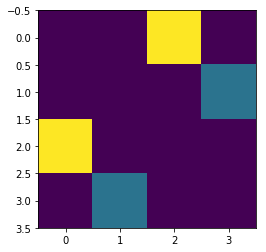

In [7]:
sigma = 1
W = Similarities(X,sigma)
plt.imshow(W)

Now, we define two methods to calculate density functions from datas :

In [8]:
def methode_Noyau(data, K=ss.norm.pdf):
    nsamples = len(data)
    sigma = data.std()
    h = sigma/nsamples**(0.2) # thumb rule
    densite = lambda y : np.sum([K((y-x)/h) for x in data])/(nsamples*h)
    return densite

def methode_MC(data):
    ensemble_des_valeurs, Nb_occurences = np.unique(data, return_counts=True)
    prob =  Nb_occurences/np.sum(Nb_occurences)
    return ensemble_des_valeurs, prob

We plot the density got from an agent labelled $y=1$.

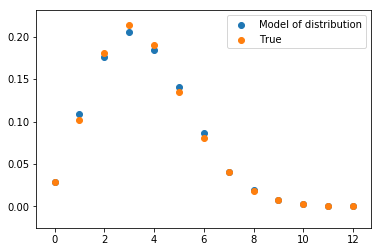

In [9]:
data = DATA[i]
ensemble_des_valeurs, prob = methode_MC(data)
plt.scatter(ensemble_des_valeurs, prob, label='Model of distribution')
plt.scatter(ensemble_des_valeurs, ss.poisson.pmf(ensemble_des_valeurs,np.linalg.norm(X[i])), label='True')
plt.legend()

We plot the density got from an agent labelled $y=2$.

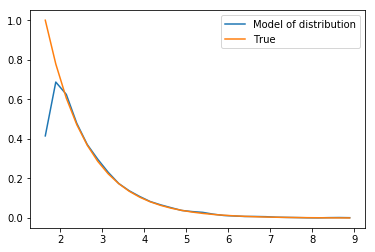

In [10]:
data = DATA[j]
densite = methode_Noyau(data)
tt = np.linspace(np.min(data), np.max(data), 30)
plt.plot(tt, [densite(t) for t in tt], label='Model of distribution')
plt.plot(tt, ss.expon.pdf(tt,np.linalg.norm(X[j])), label='True')
plt.legend()

Once we have the densities, we need the functions $g_s(v)$. Firstly, we define the cumulative empirical function $F$, and then $g$ represents its inverse. 

In [11]:
def F(data):
    nsamples = len(data)
    data_sorted = np.sort(data)
    return lambda t : bisect.bisect(data_sorted,t)/nsamples

def g(data):
    nsamples = len(data)
    ensemble_des_valeurs, Nb_occurences = np.unique(data, return_counts=True)
    prob_cum = np.cumsum(Nb_occurences)/nsamples
    return prob_cum, ensemble_des_valeurs

For $u,v$ two neighbors, we plot $g_s(u)$ and $g_s(v)$ :

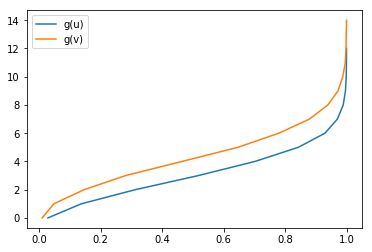

In [12]:
G = [g(data) for data in DATA]
u = np.random.randint(npeers)
v = np.argmax(W[u])

xx, yy = G[u]
plt.plot(xx, yy, label='g(u)')
xx, yy = G[v]
plt.plot(xx, yy, label='g(v)')
plt.legend()

We find that neighbor agents have very similar distributions. In conclusion, they can exchange information to better learn their models.

In [26]:
xx = np.linspace(0, 1, nsamples)
# invcdf = [icdf.InvCdf(nsamples_icdf=nsamples) for k in range(npeers)]
invcdf = [icdf.InvCdf(nsamples, np.interp(xx, G[k][0], G[k][1])) for k in range(npeers)]
# for i in range(0, len(invcdf)):
#     invcdf[i].fill_from_data(DATA[i])

# Stack agents in a list
agents = [anet.Agent(npeers, k, invcdf[k]) for k in range(npeers)]

In [27]:
# Confidence of 1 in every model
C = np.ones(npeers)

# Build network
network = anet.AgentNetwork(W, C, agents, mu=1)

In [28]:
# Run asynchronous gossip algorithm
network.iterate_async_gossip(0)
# Update finale model for each agents
network.update_invcdf_models()
# Une fois que cela est fait, pour chaque agent la seule chose qui nous interesse 
# Est l'attribut "invcdf_model" qui contient un objet InvCdf qui contient la fonction de répartition inverse
# de la distribution apprise par l'agent
# On les stocke dans une list
invcdfs = [network.agents[i].invcdf_model for i in range(0, npeers)]
# Fill the cdf from those models for each agent
for invcdf in invcdfs:
    # WARNING : Il faut adapter start et stop à ta distribution (c'est la fenetre ou tu prend la cdf)
    invcdf.fill_cdf(start=-1, stop=10, nsamples_cdf=10000)

Text(0.5, 1.0, 'Propagated cdfs')

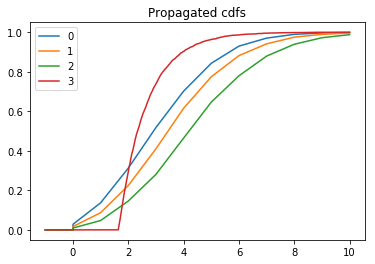

In [29]:
invcdfs = [network.agents[i].invcdf_model for i in range(0, npeers)]# Plot propagated cdfs
plt.figure()
for i in range(0, npeers):
    plt.plot(invcdfs[i].ts, invcdfs[i].cdf, label=i)
plt.legend()
plt.title("Propagated cdfs")